# Create Figures for Manuscript
Author: Caitlin Guccione

### Imports

In [1]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
group_colors = {
            'Method 1': 'skyblue',
            'Method 2': 'lightgreen',
            'Method 3': 'salmon',
            'Raw': 'grey'
        }

In [3]:
ad_df = pd.read_csv('ad_sample_info.tsv', sep ='\t')
ad_df['sample_name'] = ad_df['sample_name'].str.replace('.', '_')

/tmp/ipykernel_8464/3143424333.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  ad_df['sample_name'] = ad_df['sample_name'].str.replace('.', '_')


In [4]:
ps_df = pd.read_csv('PS_sample_info.tsv', sep ='\t')

### Figure 1D : Method Run Time

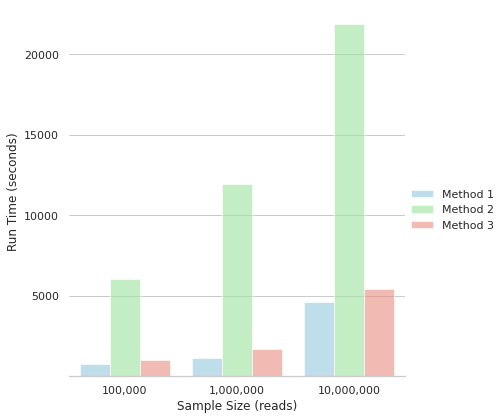

In [3]:
sns.set_theme(style="whitegrid")

avg_times = pd.read_csv('../data/cg.calc_time/average_times.txt', sep = '\t')
#vg_times['run_time']=avg_times['run_time']/60

group_colors = {
        'Method 1': 'skyblue',
        'Method 2': 'lightgreen',
        'Method 3': 'salmon',
    }

# Draw a nested barplot by species and sex
g = sns.catplot(
    data=avg_times, kind="bar",
    x="file_size", y="run_time", hue="Method",
    palette=group_colors, alpha=.6, height=6
)

'''
plt.yscale("log")

# Set y-axis ticks to specific values in log scale
y_ticks = [10**i for i in range(int(np.floor(0)), int(np.ceil(np.log10(avg_times['run_time'].max()))) + 1)]
plt.yticks(y_ticks, [str(int(i)) for i in y_ticks])
'''

# Set y-axis limits to start from log(1)
plt.ylim(bottom=1)

g.despine(left=True)
g.set_axis_labels("Sample Size (reads)", "Run Time (seconds)")
g.legend.set_title("")
    
plt.savefig('Figure1B.svg')
plt.show()

### Figure 1 E/F: Human and Microbial Reads Remaning in Simulation

In [34]:
def stats_plot_p1(file_paths, fn):
    
    sns.set_theme(style="whitegrid")

    # read and merge all tsvs
    df_list = []
    for file_path in file_paths:
        df = pd.read_csv(file_path, sep='\t')
        method_identifier = file_path.split('/host_depleted/')[1].split('/')[0]
        df['prefix'] = df['file'].apply(lambda x: x.split('/')[-1].split('.')[0])
        df['method group'] = 'Method ' + method_identifier.split('_')[-1].lstrip('m')
        df_list.append(df)
    merged_df = pd.concat(df_list, ignore_index=True)
    #Line count: total number of lines
    #Microbe/Human count: total appearences of microbe/human, this happens in R1 and R2 so if want total/2
    merged_df['human reads'] = (merged_df['human count']/2)
    merged_df['microbe reads'] = (merged_df['microbe count']/2)

    display(merged_df[:2])
    
    # start creating subplots
    width_ratios = [3, 2, 1]
    fig, axes = plt.subplots(1, 3, figsize=(12, 6), sharey=True, gridspec_kw={'width_ratios': width_ratios})
    # plot for each method group
    for i, (method_group, ax) in enumerate(zip(merged_df['method group'].unique(), axes.flatten())):
        group_data = merged_df[merged_df['method group'] == method_group]

        # Box plot
        sns.boxplot(x='key', y='human reads', hue='method group', data=group_data, palette=group_colors, ax=ax)

        # Strip plot
        sns.stripplot(x='key', y='human reads', hue='method group', data=group_data, color='black', size=4, jitter=True, ax=ax)

        ax.set_title(f'{method_group}')
        ax.set_ylabel('Remaining Human Read Count' if i == 0 else '')
        ax.set_xlabel('')
        ax.set_xticklabels(group_data['key'].unique(), rotation=45)
        ax.legend().set_visible(False)
    
    #'''
    plt.yscale("log")

    # Set y-axis ticks to specific values in log scale
    y_ticks = [10**i for i in range(int(np.floor(0)), int(np.ceil(np.log10(group_data['human reads'].max()))) + 1)]
    plt.yticks(y_ticks, [str(int(i)) for i in y_ticks])

    # Set y-axis limits to start from log(1)
    plt.ylim(bottom=1)
    #'''
        
    # Show the plot
    plt.tight_layout()
    plt.savefig('Figure1C_' + fn + '_p1.svg')
    plt.show()

In [30]:
def stats_plot_p2(file_paths, fn, microbe_total):
    
    sns.set_theme(style="whitegrid")

    # read and merge all tsvs
    df_list = []
    for file_path in file_paths:
        df = pd.read_csv(file_path, sep='\t')
        method_identifier = file_path.split('/host_depleted/')[1].split('/')[0]
        df['prefix'] = df['file'].apply(lambda x: x.split('/')[-1].split('.')[0])
        df['method group'] = 'Method ' + method_identifier.split('_')[-1].lstrip('m')
        df_list.append(df)
    merged_df = pd.concat(df_list, ignore_index=True)
    #Line count: total number of lines
    #Microbe/Human count: total appearences of microbe/human, this happens in R1 and R2 so if want total/2
    merged_df['human reads'] = (merged_df['human count']/2)
    merged_df['microbe reads'] = (merged_df['microbe count']/2)
    merged_df['microbes lost'] = (microbe_total - merged_df['microbe reads'])

    display(merged_df[:2])
    
    # start creating subplots
    width_ratios = [3, 2, 1]
    fig, axes = plt.subplots(1, 3, figsize=(12, 6), sharey=True, gridspec_kw={'width_ratios': width_ratios})
    # plot for each method group
    for i, (method_group, ax) in enumerate(zip(merged_df['method group'].unique(), axes.flatten())):
        group_data = merged_df[merged_df['method group'] == method_group]

        # Box plot
        sns.boxplot(x='key', y='microbes lost', hue='method group', data=group_data, palette=group_colors, ax=ax)

        # Strip plot
        sns.stripplot(x='key', y='microbes lost', hue='method group', data=group_data, color='black', size=4, jitter=True, ax=ax)

        ax.set_title(f'{method_group}')
        ax.set_ylabel('Microbial Reads Lost' if i == 0 else '')
        ax.set_xlabel('')
        ax.set_xticklabels(group_data['key'].unique(), rotation=45)
        ax.legend().set_visible(False)
    
    '''
    plt.yscale("log")

    # Set y-axis ticks to specific values in log scale
    y_ticks = [10**i for i in range(int(np.floor(0)), int(np.ceil(np.log10(group_data['microbes lost'].max()))) + 1)]
    plt.yticks(y_ticks, [str(int(i)) for i in y_ticks])

    # Set y-axis limits to start from log(1)
    plt.ylim(bottom=1)
    '''
        
    # Show the plot
    plt.tight_layout()
    plt.savefig('Figure1C_' + fn + '_p2.svg')
    plt.show()

In [46]:
def stats_plot_p2(file_paths, microbe_total, fn):
    
    sns.set_theme(style="whitegrid")

    # read and merge all tsvs
    df_list = []
    for file_path in file_paths:
        df = pd.read_csv(file_path, sep='\t')
        method_identifier = file_path.split('/host_depleted/')[1].split('/')[0]
        df['prefix'] = df['file'].apply(lambda x: x.split('/')[-1].split('.')[0])
        df['method group'] = 'Method ' + method_identifier.split('_')[-1].lstrip('m')
        df_list.append(df)
    merged_df = pd.concat(df_list, ignore_index=True)
    merged_df['microbes lost'] = microbe_total - merged_df['microbe count']
    #display(merged_df[:2])

    group_colors = {
            'Method 1': 'skyblue',
            'Method 2': 'lightgreen',
            'Method 3': 'salmon',
        }
    
    
    # start creating subplots
    width_ratios = [3, 2, 1]
    fig, axes = plt.subplots(1, 3, figsize=(12, 6), sharey=True, gridspec_kw={'width_ratios': width_ratios})

    group_colors = {'Method 1': 'skyblue', 'Method 2': 'lightgreen', 'Method 3': 'salmon'}

    # plot for each method group
    for i, (method_group, ax) in enumerate(zip(merged_df['method group'].unique(), axes.flatten())):
        group_data = merged_df[merged_df['method group'] == method_group]

        # Box plot
        sns.boxplot(x='key', y='microbes lost', hue='method group', data=group_data, palette=group_colors, ax=ax)

        # Strip plot
        sns.stripplot(x='key', y='microbes lost', hue='method group', data=group_data, color='black', size=4, jitter=True, ax=ax)

        ax.set_title(f'{method_group}')
        ax.set_ylabel('Lost Microbial Reads' if i == 0 else '')
        ax.set_xlabel('')
        ax.set_xticklabels(group_data['key'].unique(), rotation=45)
        ax.legend().set_visible(False)

    '''
    plt.yscale("log")

    # Set y-axis ticks to specific values in log scale
    y_ticks = [10**i for i in range(int(np.floor(0)), int(np.ceil(np.log10(group_data['human count'].max()))) + 1)]
    plt.yticks(y_ticks, [str(int(i)) for i in y_ticks])

    # Set y-axis limits to start from log(1)
    plt.ylim(bottom=1)
    '''
        
    # Show the plot
    plt.tight_layout()
    plt.savefig('Figure1C_' + fn +'_p2.svg')
    plt.show()

,file,key,line count,human count,microbe count,TP,FP,TN,FN,prefix,method group,human reads,microbe reads
0,/panfs/cguccion/23_11_07_HostDepletionBenchmar...,ALIGN-HG38,4000464,304,999812,999696,188,999812,304,50,Method 1,152.0,499906.0
1,/panfs/cguccion/23_11_07_HostDepletionBenchmar...,ALIGN-HG38,4004552,1322,999816,998678,184,999816,1322,50,Method 1,661.0,499908.0


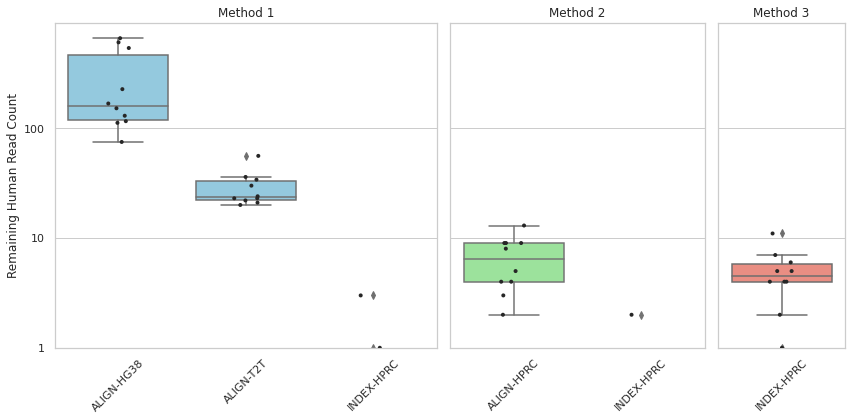

,file,key,line count,human count,microbe count,TP,FP,TN,FN,prefix,method group,human reads,microbe reads,microbes lost
0,/panfs/cguccion/23_11_07_HostDepletionBenchmar...,ALIGN-HG38,4000464,304,999812,999696,188,999812,304,50,Method 1,152.0,499906.0,94.0
1,/panfs/cguccion/23_11_07_HostDepletionBenchmar...,ALIGN-HG38,4004552,1322,999816,998678,184,999816,1322,50,Method 1,661.0,499908.0,92.0


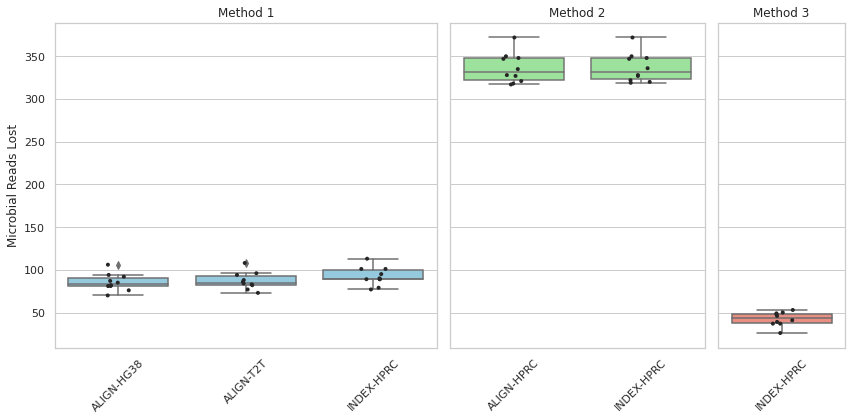

In [35]:
paths_1M_stat_m1 = ['/panfs/cguccion/23_11_07_HostDepletionBenchmarkOverflow/mixed_simulation_tmp/final_combo/LITTLE_50.00p-HUMAN_50.00p-MICROBE/host_depleted/1M_stat_m1/align-hg38/summary_statistics.tsv',
              '/panfs/cguccion/23_11_07_HostDepletionBenchmarkOverflow/mixed_simulation_tmp/final_combo/LITTLE_50.00p-HUMAN_50.00p-MICROBE/host_depleted/1M_stat_m1/align-t2t/summary_statistics.tsv',
              '/panfs/cguccion/23_11_07_HostDepletionBenchmarkOverflow/mixed_simulation_tmp/final_combo/LITTLE_50.00p-HUMAN_50.00p-MICROBE/host_depleted/1M_stat_m1/index-hprc/summary_statistics.tsv',
              '/panfs/cguccion/23_11_07_HostDepletionBenchmarkOverflow/mixed_simulation_tmp/final_combo/LITTLE_50.00p-HUMAN_50.00p-MICROBE/host_depleted/1M_stat_m2/align-hprc/summary_statistics.tsv',
              '/panfs/cguccion/23_11_07_HostDepletionBenchmarkOverflow/mixed_simulation_tmp/final_combo/LITTLE_50.00p-HUMAN_50.00p-MICROBE/host_depleted/1M_stat_m2/index-hprc/summary_statistics.tsv',
              '/panfs/cguccion/23_11_07_HostDepletionBenchmarkOverflow/mixed_simulation_tmp/final_combo/LITTLE_50.00p-HUMAN_50.00p-MICROBE/host_depleted/1M_stat_m3/index-hprc/summary_statistics.tsv']

stats_plot_p1(paths_1M_stat_m1, '50-50')
stats_plot_p2(paths_1M_stat_m1,  '50-50', 500000) #Number of microbial READS in input

### Figure 2A : Exome

In [54]:
def exome_plot(file_paths):
    
    sns.set_theme(style="whitegrid")

    # read and merge all tsvs
    df_list = []
    for file_path in file_paths:
        df = pd.read_csv(file_path, sep='\t')
        method_identifier = file_path.split('/host_depleted/')[1].split('/')[0]
        df['prefix'] = df['file'].apply(lambda x: x.split('/')[-1].split('.')[0])
        df['method group'] = 'Method ' + method_identifier.split('_')[-1].lstrip('m')
        df_list.append(df)
    merged_df = pd.concat(df_list, ignore_index=True)
    #Line count: total number of lines
    merged_df['remaining reads'] = (merged_df['line count']/8) #4 for fastq, then 2 for R1/R2

    display(merged_df[:2])
    
    # start creating subplots
    width_ratios = [3, 2, 1]
    fig, axes = plt.subplots(1, 3, figsize=(12, 6), sharey=True, gridspec_kw={'width_ratios': width_ratios})
    # plot for each method group
    for i, (method_group, ax) in enumerate(zip(merged_df['method group'].unique(), axes.flatten())):
        group_data = merged_df[merged_df['method group'] == method_group]

        # Box plot
        sns.boxplot(x='key', y='remaining reads', hue='method group', data=group_data, palette=group_colors, ax=ax)

        # Strip plot
        sns.stripplot(x='key', y='remaining reads', hue='method group', data=group_data, color='black', size=4, jitter=True, ax=ax)

        ax.set_title(f'{method_group}')
        ax.set_ylabel('Human Exome Reads Remaining' if i == 0 else '')
        ax.set_xlabel('')
        ax.set_xticklabels(group_data['key'].unique(), rotation=45)
        ax.legend().set_visible(False)
    
    #'''
    plt.yscale("log")

    # Set y-axis ticks to specific values in log scale
    y_ticks = [10**i for i in range(int(np.floor(0)), int(np.ceil(np.log10(group_data['remaining reads'].max()))) + 1)]
    plt.yticks(y_ticks, [str(int(i)) for i in y_ticks])

    # Set y-axis limits to start from log(1)
    plt.ylim(bottom=1)
    #'''
        
    # Show the plot
    plt.tight_layout()
    plt.savefig('Figure1E_exome.svg')
    plt.show()

,file,key,line count,prefix,method group,remaining reads
0,/panfs/cguccion/23_11_07_HostDepletionBenchmar...,align-hg38,5272,1M_ERR031856,Method 1,659.0
1,/panfs/cguccion/23_11_07_HostDepletionBenchmar...,align-hg38,3976,1M_ERR031887,Method 1,497.0


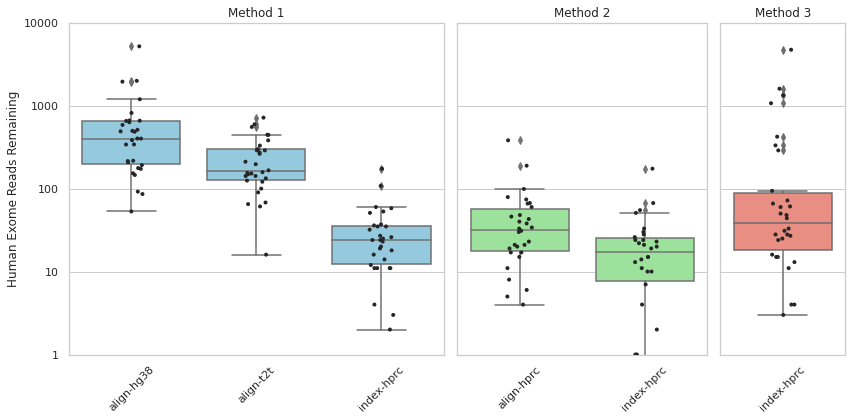

In [55]:
paths_exome_1M_m1 = ['/panfs/cguccion/23_11_07_HostDepletionBenchmarkOverflow/exome/host_depleted/exome_1M_m1/align-hg38/summary_statistics.tsv',
              '/panfs/cguccion/23_11_07_HostDepletionBenchmarkOverflow/exome/host_depleted/exome_1M_m1/align-t2t/summary_statistics.tsv',
              '/panfs/cguccion/23_11_07_HostDepletionBenchmarkOverflow/exome/host_depleted/exome_1M_m1/index-hprc/summary_statistics.tsv',
              '/panfs/cguccion/23_11_07_HostDepletionBenchmarkOverflow/exome/host_depleted/exome_1M_m2/align-hprc/summary_statistics.tsv',
              '/panfs/cguccion/23_11_07_HostDepletionBenchmarkOverflow/exome/host_depleted/exome_1M_m2/index-hprc/summary_statistics.tsv',
              '/panfs/cguccion/23_11_07_HostDepletionBenchmarkOverflow/exome/host_depleted/exome_1M_m3/index-hprc/summary_statistics.tsv']

exome_plot(paths_exome_1M_m1)

### Figure 2B (HMF)

In [63]:
def hmf_plot(file_paths):
    
    sns.set_theme(style="whitegrid")

    # read and merge all tsvs
    df_list = []
    for file_path in file_paths:
        df = pd.read_csv(file_path, sep='\t')
        if '100_subset' in file_path:
            method_identifier = 'Raw'
            df = df[~df['file'].str.contains('R2')]
            df['line count'] = df['line count']*2
            df['method group'] = method_identifier.split('_')[-1].lstrip('m')
            df['prefix'] = df['file'].apply(lambda x: x.split('/')[-1].split('.')[0]).str.replace('_R1', '')
            # Create a mapping dictionary from df1
            mapping_dict = dict(zip(df['prefix'], df['line count']))

        else:
            method_identifier = file_path.split('/host_depleted/')[1].split('/')[0]
            df['method group'] = 'Method ' + method_identifier.split('_')[-1].lstrip('m')
            df['prefix'] = df['file'].apply(lambda x: x.split('/')[-1].split('.')[0])
            df['raw line count'] = df['prefix'].map(mapping_dict)
            df_list.append(df)
    merged_df = pd.concat(df_list, ignore_index=True)
    #Line count: total number of lines, Raw line count: total number of lines in Raw
    merged_df['percentage of reads kept'] = ((merged_df['line count']/8)/(merged_df['raw line count']/8)) *100 #4 for fastq, then 2 for R1/R2
    merged_df['total read count'] = merged_df['line count']/8
    
    display(merged_df[:2])
    
    # start creating subplots
    width_ratios = [3, 2, 1]
    fig, axes = plt.subplots(1, 3, figsize=(12, 6), sharey=True, gridspec_kw={'width_ratios': width_ratios})
    # plot for each method group
    for i, (method_group, ax) in enumerate(zip(merged_df['method group'].unique(), axes.flatten())):
        group_data = merged_df[merged_df['method group'] == method_group]

        # Box plot
        sns.boxplot(x='key', y='total read count', hue='method group', data=group_data, palette=group_colors, ax=ax)

        # Strip plot
        sns.stripplot(x='key', y='total read count', hue='method group', data=group_data, color='black', size=4, jitter=True, ax=ax)

        ax.set_title(f'{method_group}')
        #ax.set_ylabel('Percentage of Tissue Sample Reads Remaining' if i == 0 else '')
        ax.set_ylabel('Tissue Sample Read Count' if i == 0 else '')
        ax.set_xlabel('')
        ax.set_xticklabels(group_data['key'].unique(), rotation=45)
        ax.legend().set_visible(False)   
    
    '''
    plt.yscale("log")

    # Set y-axis ticks to specific values in log scale
    y_ticks = [5**i for i in range(int(np.floor(0)), int(np.ceil(np.log10(group_data['total read count'].max()))) + 1)]
    plt.yticks(y_ticks, [str(int(i)) for i in y_ticks])

    # Set y-axis limits to start from log(1)
    #plt.ylim(bottom=1)
    '''
    
    #plt.ylim(97.75, 98.75) 
    plt.yscale("log")
        
    # Show the plot
    plt.tight_layout()
    plt.savefig('Figure2A_HMF_.svg')
    plt.show()

,file,key,line count,method group,prefix,raw line count,percentage of reads kept,total read count
0,/panfs/cguccion/23_11_07_HostDepletionBenchmar...,ALIGN-HG38,2112,Method 1,ACTN01020009T,2888,73.130194,264.0
1,/panfs/cguccion/23_11_07_HostDepletionBenchmar...,ALIGN-HG38,467368,Method 1,CPCT02010336T_dedup,1265512,36.931139,58421.0


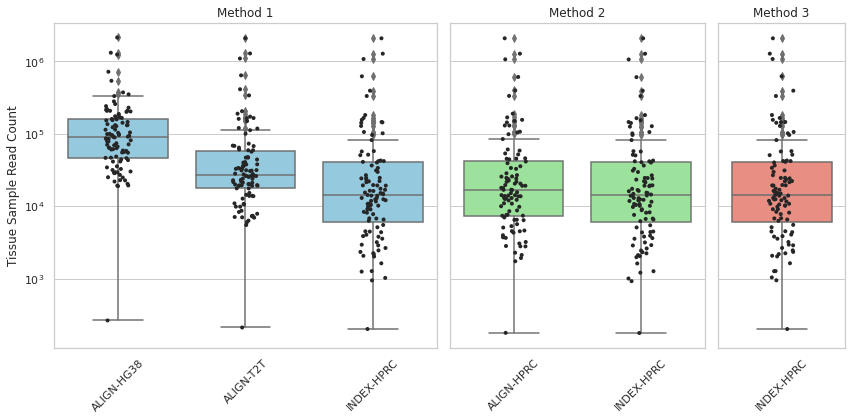

In [64]:
paths_hmf_100_m1 = ['/panfs/cguccion/23_11_07_HostDepletionBenchmarkOverflow/hmf/qiita14382_prep5_colon/140717/100_subset/summary_statistics.tsv',
              '/panfs/cguccion/23_11_07_HostDepletionBenchmarkOverflow/hmf/host_depleted/hmf_100_m1/align-hg38/summary_statistics.tsv',
              '/panfs/cguccion/23_11_07_HostDepletionBenchmarkOverflow/hmf/host_depleted/hmf_100_m1/align-t2t/summary_statistics.tsv',
              '/panfs/cguccion/23_11_07_HostDepletionBenchmarkOverflow/hmf/host_depleted/hmf_100_m1/index-hprc/summary_statistics.tsv',
              '/panfs/cguccion/23_11_07_HostDepletionBenchmarkOverflow/hmf/host_depleted/hmf_100_m2/align-hprc/summary_statistics.tsv',
              '/panfs/cguccion/23_11_07_HostDepletionBenchmarkOverflow/hmf/host_depleted/hmf_100_m2/index-hprc/summary_statistics.tsv',
              '/panfs/cguccion/23_11_07_HostDepletionBenchmarkOverflow/hmf/host_depleted/hmf_100_m3/index-hprc/summary_statistics.tsv']

hmf_plot(paths_hmf_100_m1)

### Figure 2C - Skin AD

In [ ]:
def skin_plot(file_paths):
    
    sns.set_theme(style="whitegrid")

    # read and merge all tsvs
    df_list = []
    for file_path in file_paths:
        df = pd.read_csv(file_path, sep='\t')
        if 'raw' in file_path:
            method_identifier = 'Raw'
            df = df[~df['file'].str.contains('R2')]
            df['line count'] = df['line count']*2
            df['method group'] = method_identifier.split('_')[-1].lstrip('m')
            df['prefix'] = df['file'].apply(lambda x: x.split('/')[-1].split('.')[0]).str.replace('_R1', '')
            # Create a mapping dictionary from df1
            mapping_dict = dict(zip(df['prefix'], df['line count']))

        else:
            method_identifier = file_path.split('/host_depleted/')[1].split('/')[0]
            df['method group'] = 'Method ' + method_identifier.split('_')[-1].lstrip('m')
            df['prefix'] = df['file'].apply(lambda x: x.split('/')[-1].split('.')[0])
            df['raw line count'] = df['prefix'].map(mapping_dict)
            df_list.append(df) 
    merged_df = pd.concat(df_list, ignore_index=True)
    #Line count: total number of lines, Raw line count: total number of lines in Raw
    merged_df['percentage of reads kept'] = ((merged_df['line count']/8)/(merged_df['raw line count']/8)) *100 #4 for fastq, then 2 for R1/R2
    merged_df['total read count'] = merged_df['line count']/8
    
    #Add sample info
    sample_dict_microbe = dict(zip(ad_df['sample_name'], ad_df['microbiome_type']))
    sample_dict_body = dict(zip(ad_df['sample_name'], ad_df['body_site']))
    sample_dict_les = dict(zip(ad_df['sample_name'], ad_df['les_or_nonles']))
    sample_dict_sex = dict(zip(ad_df['sample_name'], ad_df['sex']))
    sample_dict_status = dict(zip(ad_df['sample_name'], ad_df['AD_status']))
    merged_df['microbiome_type'] = merged_df['prefix'].map(sample_dict_microbe)
    merged_df['body_site'] = merged_df['prefix'].map(sample_dict_body)
    merged_df['les_or_nonles'] = merged_df['prefix'].map(sample_dict_les)
    merged_df['sex'] = merged_df['prefix'].map(sample_dict_sex)
    merged_df['AD_status'] = merged_df['prefix'].map(sample_dict_status)
    merged_df['AD_status_les'] = merged_df['AD_status'] + '_' + merged_df['les_or_nonles'] 
    
    #Remove oral samples
    merged_df = merged_df[merged_df['microbiome_type'].isin(['human_skin'])]
    
    #Subset to Yang's request
    #merged_df = merged_df[merged_df['AD_status_les'].isin(['AD_pos_L'])]
    
    #Remove problematic samples to make everything even
    # Count occurrences of each prefix
    prefix_counts = merged_df['prefix'].value_counts()
    # Filter prefixes that occur at least 6 times
    valid_prefixes = prefix_counts[prefix_counts >= 6].index
    # Filter the DataFrame based on valid prefixes
    merged_df = merged_df[merged_df['prefix'].isin(valid_prefixes)]

    display(merged_df[:2])
    
    # start creating subplots
    width_ratios = [3, 2, 1]
    fig, axes = plt.subplots(1, 3, figsize=(12, 6), sharey=True, gridspec_kw={'width_ratios': width_ratios})
    # plot for each method group
    for i, (method_group, ax) in enumerate(zip(merged_df['method group'].unique(), axes.flatten())):
        group_data = merged_df[merged_df['method group'] == method_group]

        # Box plot
        sns.boxplot(x='key', y='percentage of reads kept', hue='method group', data=group_data, palette=group_colors, ax=ax)
        #sns.boxplot(x='key', y='total read count', hue='method group', data=group_data, palette=group_colors, ax=ax)
        
        # Strip plot
        sns.stripplot(x='key', y='percentage of reads kept', hue='method group', data=group_data, color='black', size=4, jitter=True, ax=ax)
        #sns.stripplot(x='key', y='total read count', hue='method group', data=group_data, color='black', size=4, jitter=True, ax=ax)
        
        ax.set_title(f'{method_group}')
        ax.set_ylabel('Percentage of Skin Sample Reads Remaining' if i == 0 else '')
        #ax.set_ylabel('Skin Sample Read Count' if i == 0 else '')
        ax.set_xlabel('')
        ax.set_xticklabels(group_data['key'].unique(), rotation=45)
        ax.legend().set_visible(False)   
    
    '''
    plt.yscale("log")

    # Set y-axis ticks to specific values in log scale
    y_ticks = [10**i for i in range(int(np.floor(0)), int(np.ceil(np.log10(group_data['percentage of reads kept'].max()))) + 1)]
    plt.yticks(y_ticks, [str(int(i)) for i in y_ticks])

    # Set y-axis limits to start from log(1)
    #plt.ylim(bottom=1)
    '''
    
    #plt.ylim(0, 20) 
    plt.yscale("log")
        
        
    # Show the plot
    plt.tight_layout()
    plt.savefig('Figure1_skin_.svg')
    #plt.savefig('Figure1_skin_.png')
    plt.show()
    
    merged_df_sorted = merged_df.sort_values(by='percentage of reads kept', ascending=False)
    merged_df_sorted.to_csv('AD.tsv', '\t')

,file,key,line count,method group,prefix,raw line count,percentage of reads kept,total read count,microbiome_type,body_site,les_or_nonles,sex,AD_status,AD_status_les
3,/panfs/cguccion/23_11_07_HostDepletionBenchmar...,align-hg38,20925680,Method 1,110_S20_L005,66436480,31.497274,2615710.0,human_skin,cheek,L,M,AD_pos,AD_pos_L
7,/panfs/cguccion/23_11_07_HostDepletionBenchmar...,align-hg38,7136808,Method 1,117_S24_L005,89913736,7.937395,892101.0,human_skin,cheek,L,M,AD_pos,AD_pos_L


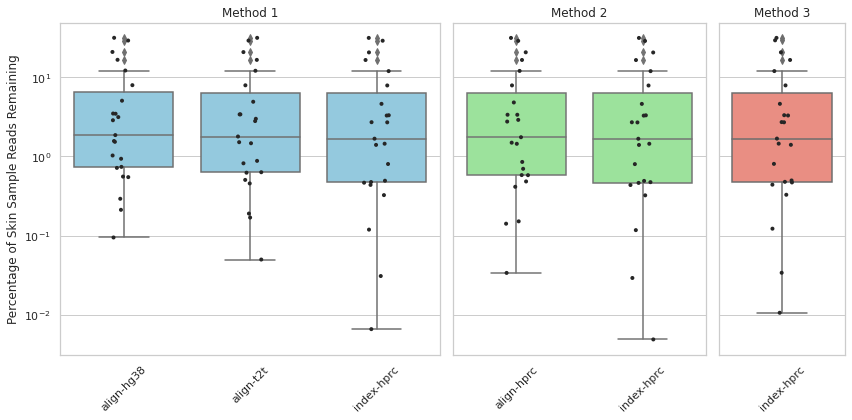

In [19]:
paths_skin = ['/panfs/cguccion/23_11_07_HostDepletionBenchmarkOverflow/AD/raw/summary_statistics.tsv',
    '/panfs/cguccion/23_11_07_HostDepletionBenchmarkOverflow/AD/host_depleted/AD_m1/align-hg38/summary_statistics.tsv',
    '/panfs/cguccion/23_11_07_HostDepletionBenchmarkOverflow/AD/host_depleted/AD_m1/align-t2t/summary_statistics.tsv',
    '/panfs/cguccion/23_11_07_HostDepletionBenchmarkOverflow/AD/host_depleted/AD_m1/index-hprc/summary_statistics.tsv',
    '/panfs/cguccion/23_11_07_HostDepletionBenchmarkOverflow/AD/host_depleted/AD_m2/align-hprc/summary_statistics.tsv',
    '/panfs/cguccion/23_11_07_HostDepletionBenchmarkOverflow/AD/host_depleted/AD_m2/index-hprc/summary_statistics.tsv',
    '/panfs/cguccion/23_11_07_HostDepletionBenchmarkOverflow/AD/host_depleted/AD_m3/index-hprc/summary_statistics.tsv']

skin_plot(paths_skin)

### Figure 2 D: Fecal

In [23]:
def u19_plot(file_paths):
    
    sns.set_theme(style="whitegrid")

    # read and merge all tsvs
    df_list = []
    for file_path in file_paths:
        df = pd.read_csv(file_path, sep='\t')
        if 'raw' in file_path:
            method_identifier = 'Raw'
            df = df[~df['file'].str.contains('R2')]
            df['line count'] = df['line count']*2
            df['method group'] = method_identifier.split('_')[-1].lstrip('m')
            df['prefix'] = df['file'].apply(lambda x: x.split('/')[-1].split('.')[0]).str.replace('_R1', '')
            # Create a mapping dictionary from df1
            mapping_dict = dict(zip(df['prefix'], df['line count']))

        else:
            method_identifier = file_path.split('/host_depleted/')[1].split('/')[0]
            df['method group'] = 'Method ' + method_identifier.split('_')[-1].lstrip('m')
            df['prefix'] = df['file'].apply(lambda x: x.split('/')[-1].split('.')[0])
            df['raw line count'] = df['prefix'].map(mapping_dict)
            df_list.append(df)
    merged_df = pd.concat(df_list, ignore_index=True)
    #Line count: total number of lines, Raw line count: total number of lines in Raw
    merged_df['percentage of reads kept'] = ((merged_df['line count']/8)/(merged_df['raw line count']/8)) *100 #4 for fastq, then 2 for R1/R2

    display(merged_df[:2])
    
    # start creating subplots
    width_ratios = [3, 2, 1]
    fig, axes = plt.subplots(1, 3, figsize=(12, 6), sharey=True, gridspec_kw={'width_ratios': width_ratios})
    # plot for each method group
    for i, (method_group, ax) in enumerate(zip(merged_df['method group'].unique(), axes.flatten())):
        group_data = merged_df[merged_df['method group'] == method_group]

        # Box plot
        sns.boxplot(x='key', y='percentage of reads kept', hue='method group', data=group_data, palette=group_colors, ax=ax)

        # Strip plot
        sns.stripplot(x='key', y='percentage of reads kept', hue='method group', data=group_data, color='black', size=4, jitter=True, ax=ax)

        ax.set_title(f'{method_group}')
        ax.set_ylabel('Percentage of Fecal Sample Reads Remaining' if i == 0 else '')
        ax.set_xlabel('')
        ax.set_xticklabels(group_data['key'].unique(), rotation=45)
        ax.legend().set_visible(False)   
    
    '''
    plt.yscale("log")

    # Set y-axis ticks to specific values in log scale
    y_ticks = [10**i for i in range(int(np.floor(0)), int(np.ceil(np.log10(group_data['percentage of reads kept'].max()))) + 1)]
    plt.yticks(y_ticks, [str(int(i)) for i in y_ticks])

    # Set y-axis limits to start from log(1)
    #plt.ylim(bottom=1)
    '''
    
    plt.ylim(94, 100)
    #plt.ylim(97.75, 98.75) 
    #plt.yscale("log")
        
        
    # Show the plot
    plt.tight_layout()
    #plt.savefig('Figure1F_U19.svg')
    plt.savefig('Figure1F_U19_50.svg')
    plt.show()

,file,key,line count,method group,prefix,raw line count,percentage of reads kept
0,/panfs/cguccion/23_11_07_HostDepletionBenchmar...,align-hg38,7606784,Method 1,mars00001_S82_L001,7730680,98.397347
1,/panfs/cguccion/23_11_07_HostDepletionBenchmar...,align-hg38,17187152,Method 1,mars00002_S94_L001,17440688,98.546296


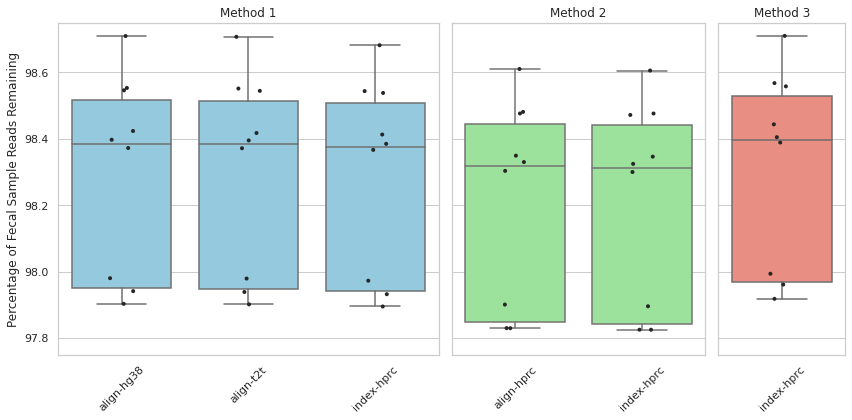

In [100]:
paths_u19_10_m1 = ['/panfs/cguccion/23_11_07_HostDepletionBenchmarkOverflow/U19/raw/summary_statistics.tsv',
    '/panfs/cguccion/23_11_07_HostDepletionBenchmarkOverflow/U19/host_depleted/u19_10_m1/align-hg38/summary_statistics.tsv',
    '/panfs/cguccion/23_11_07_HostDepletionBenchmarkOverflow/U19/host_depleted/u19_10_m1/align-t2t/summary_statistics.tsv',
    '/panfs/cguccion/23_11_07_HostDepletionBenchmarkOverflow/U19/host_depleted/u19_10_m1/index-hprc/summary_statistics.tsv',
    '/panfs/cguccion/23_11_07_HostDepletionBenchmarkOverflow/U19/host_depleted/u19_10_m2/align-hprc/summary_statistics.tsv',
    '/panfs/cguccion/23_11_07_HostDepletionBenchmarkOverflow/U19/host_depleted/u19_10_m2/index-hprc/summary_statistics.tsv',
    '/panfs/cguccion/23_11_07_HostDepletionBenchmarkOverflow/U19/host_depleted/u19_10_m3/index-hprc/summary_statistics.tsv']

u19_plot(paths_u19_10_m1)

,file,key,line count,method group,prefix,raw line count,percentage of reads kept
0,/panfs/cguccion/23_11_07_HostDepletionBenchmar...,align-hg38,12056352,Method 1,mars00010_S83_L001,12233328,98.553329
1,/panfs/cguccion/23_11_07_HostDepletionBenchmar...,align-hg38,25684392,Method 1,mars000114_S33_L001,26213904,97.980034


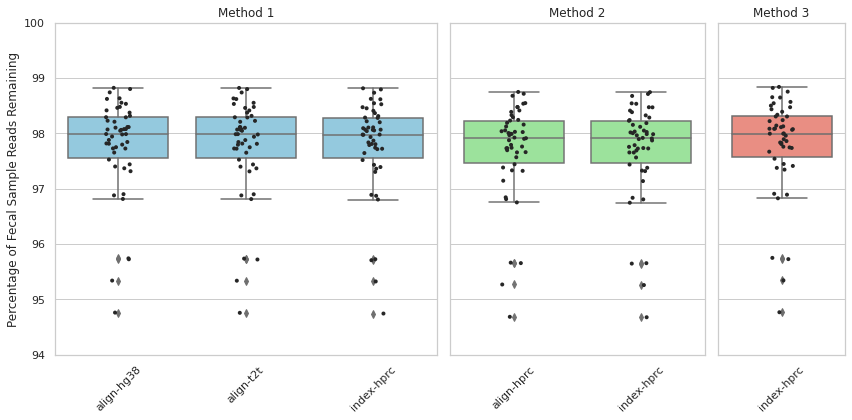

In [24]:
paths_u19_50_m1 = ['/panfs/cguccion/23_11_07_HostDepletionBenchmarkOverflow/U19/raw/raw_50_run2/summary_statistics.tsv',
    '/panfs/cguccion/23_11_07_HostDepletionBenchmarkOverflow/U19/host_depleted/u19_50_m1/align-hg38/summary_statistics.tsv',
    '/panfs/cguccion/23_11_07_HostDepletionBenchmarkOverflow/U19/host_depleted/u19_50_m1/align-t2t/summary_statistics.tsv',
    '/panfs/cguccion/23_11_07_HostDepletionBenchmarkOverflow/U19/host_depleted/u19_50_m1/index-hprc/summary_statistics.tsv',
    '/panfs/cguccion/23_11_07_HostDepletionBenchmarkOverflow/U19/host_depleted/u19_50_m2/align-hprc/summary_statistics.tsv',
    '/panfs/cguccion/23_11_07_HostDepletionBenchmarkOverflow/U19/host_depleted/u19_50_m2/index-hprc/summary_statistics.tsv',
    '/panfs/cguccion/23_11_07_HostDepletionBenchmarkOverflow/U19/host_depleted/u19_50_m3/index-hprc/summary_statistics.tsv']

u19_plot(paths_u19_50_m1)